In [1]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import rasterio
import os
from functions import *
from pathlib import Path
from scipy import stats
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
#Satellite datas directory
data_dir = Path('../Data')
shapefile = Path('../Shapefile/BegnasArea.shp')

In [40]:
# Replace 'Data' with the path to your main folder
main_folder = Path('../Data')
process_all_folders(main_folder)


Processing ../Data/LULC.tif...
Processing ../Data/LULC5m.tif...
Processing ../Data/Winter/landsat_8Winter.tif...
Calculation of NDVI, EVI, NDWI, and SAVI in progress for: landsat_8Winter
Raster file saved at: ../Data/Winter/NDVI/landsat_8WinterNDVI.tif
Raster file saved at: ../Data/Winter/EVI/landsat_8WinterEVI.tif
Raster file saved at: ../Data/Winter/NDWI/landsat_8WinterNDWI.tif
Raster file saved at: ../Data/Winter/SAVI/landsat_8WinterSAVI.tif
Processing ../Data/Winter/landsat_9Winter.tif...
Calculation of NDVI, EVI, NDWI, and SAVI in progress for: landsat_9Winter
Raster file saved at: ../Data/Winter/NDVI/landsat_9WinterNDVI.tif
Raster file saved at: ../Data/Winter/EVI/landsat_9WinterEVI.tif
Raster file saved at: ../Data/Winter/NDWI/landsat_9WinterNDWI.tif
Raster file saved at: ../Data/Winter/SAVI/landsat_9WinterSAVI.tif
Processing ../Data/Fall/landsat_9Fall.tif...
Calculation of NDVI, EVI, NDWI, and SAVI in progress for: landsat_9Fall
Raster file saved at: ../Data/Fall/NDVI/landsat_9

<span style="font-family: 'Times New Roman', Times, serif; font-size: 1.5em;">Plotting the Indexes</span>


In [3]:
# Enable LaTeX font rendering
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

/var/folders/3g/sycd83_j0fb1l3sf8r5n5j000000gn/T/ipykernel_91400/2088523189.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


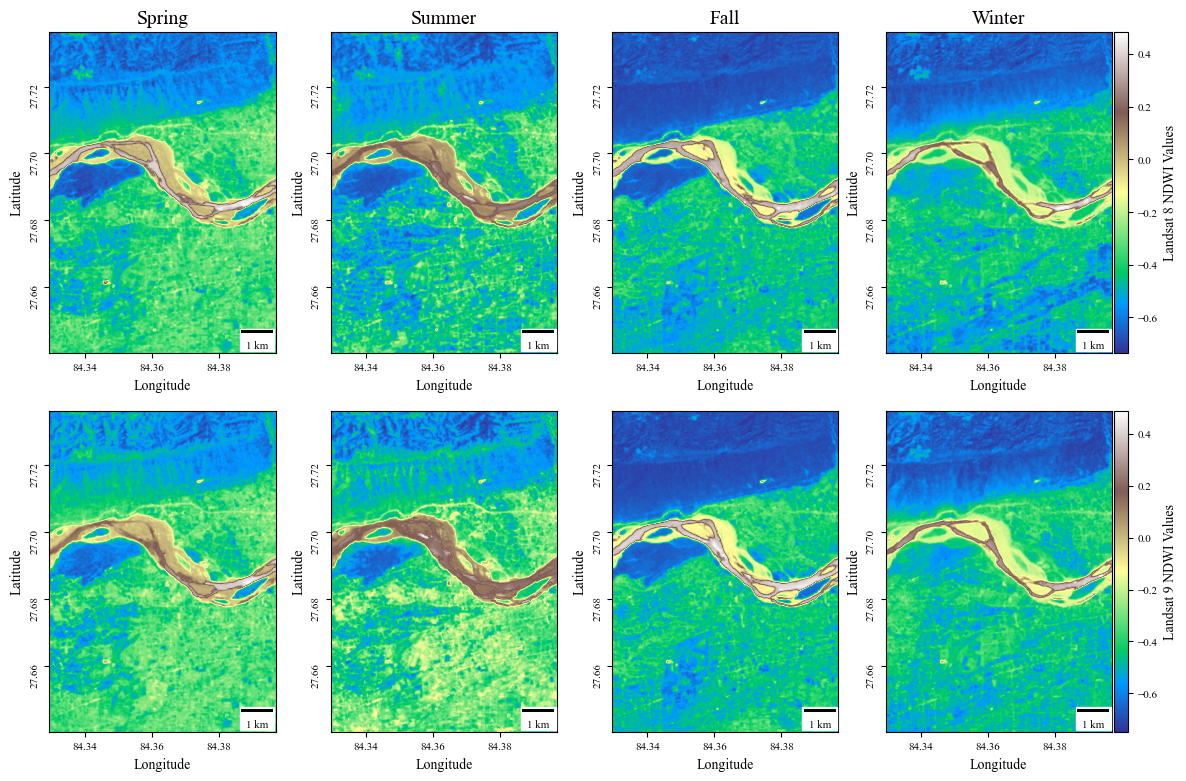

In [68]:
import os
import re
import matplotlib.pyplot as plt
import rasterio
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
from pathlib import Path
from math import cos, pi

def plot_vegetation_indices(files, title_prefix, ax, set_title=True):
    # Ensure there are files to plot
    if not files:
        ax.set_title("No data")
        ax.axis('off')
        return None

    # Assume all images have the same dimensions and use the first image to set extent
    first_file = files[0]
    dataset = rasterio.open(first_file)
    bounds = dataset.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    dataset.close()

    # Resize images to a common target size
    target_size = (512, 512)
    img = None

    # Plot the images
    for i, file in enumerate(files):
        dataset = rasterio.open(file)
        raster_data = dataset.read(1)
        dataset.close()
        
        # Resize raster data
        raster_resized = resize(raster_data, target_size, mode='reflect', anti_aliasing=True)
        
        # Display image
        img = ax.imshow(raster_resized, cmap='terrain', extent=extent)
        
        # Set title if required
        if set_title:
            ax.set_title(f'{title_prefix}', fontsize=14)
        else:
            ax.set_title('')
        
        ax.set_xlabel('Longitude', fontsize=10)
        
        # Set y-label only for the first plot in each row
        if i == 0: 
            ax.set_ylabel('Latitude', fontsize=10)
        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])  # Remove y-tick labels
        
        # Adjust tick label sizes
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=8)
        ax.yaxis.set_tick_params(rotation=90)

        # Add scale bar
        center_latitude = (bounds.top + bounds.bottom) / 2
        meters_per_degree_lat, meters_per_degree_lon = degree_to_meters(center_latitude)
        mean_meters_per_degree = (meters_per_degree_lat + meters_per_degree_lon) / 2
        scalebar = ScaleBar(mean_meters_per_degree, units='m', dimension='si-length', 
                            location='lower right', pad=0.1, font_properties={'size': 8})
        ax.add_artist(scalebar)
        
    return img  # Return the last image to use for color bar

def degree_to_meters(latitude):
    """ Convert degrees to meters for latitude and longitude. """
    # Approximate conversion factors
    meters_per_degree_lat = 111320  # meters per degree latitude
    meters_per_degree_lon = 111320 * cos(latitude * pi / 180)  # meters per degree longitude
    return meters_per_degree_lat, meters_per_degree_lon

# Define the main folder and seasons
main_folder = Path('../Data/NDWI')
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

# Initialize lists for Landsat 8 and Landsat 9 files
landsat_8_files = []
landsat_9_files = []

# Regular expression to extract the Landsat number
landsat_number_pattern = re.compile(r'(\d+)')

# Collect and classify filenames
for season in seasons:
    season_folder = os.path.join(main_folder, season)

    if os.path.exists(season_folder):
        for file in os.listdir(season_folder):
            if file.endswith('.tif'):
                match = landsat_number_pattern.search(file)
                if match:
                    landsat_number = match.group(1)
                    file_path = os.path.join(season_folder, file)
                    
                    if landsat_number == '8':
                        landsat_8_files.append(file_path)
                    elif landsat_number == '9':
                        landsat_9_files.append(file_path)
    else:
        print(f"Directory not found: {season_folder}")

# Sort files by Landsat number and then by filename
landsat_8_files.sort(key=lambda x: int(re.search(r'(\d+)', os.path.basename(x)).group()))
landsat_9_files.sort(key=lambda x: int(re.search(r'(\d+)', os.path.basename(x)).group()))

# Create subplots with adjusted spacing
fig, axs = plt.subplots(2, len(seasons), figsize=(20,10), gridspec_kw={'hspace': 0.18, 'wspace': 0.02})

# Plot Landsat 8 and Landsat 9 data
for i, season in enumerate(seasons):
    # Filter files for current season
    landsat_8_season_files = [f for f in landsat_8_files if season in os.path.basename(f)]
    landsat_9_season_files = [f for f in landsat_9_files if season in os.path.basename(f)]
    
    # Plot Landsat 8
    img_8 = plot_vegetation_indices(landsat_8_season_files, f'{season}', axs[0, i], set_title=True)
    
    # Plot Landsat 9
    img_9 = plot_vegetation_indices(landsat_9_season_files, f'{season}', axs[1, i], set_title=False)

# Add common color bars
for i in range(2):
    ax = axs[i, -1]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad = 0.02)
    colorbar = plt.colorbar(img_8 if i == 0 else img_9, cax=cax, orientation='vertical')
    if i == 0:
        colorbar.set_label('Landsat 8 NDWI Values', rotation=90)
    else:
        colorbar.set_label('Landsat 9 NDWI Values', rotation=90)
    colorbar.ax.tick_params(labelsize=8)

# Adjust layout and save the plot
fig.tight_layout()
plt.subplots_adjust(left=0.02, right=0.58, top=0.8, bottom=0.1)
plt.savefig('../Images/NDWI.png', dpi=500, bbox_inches='tight')
plt.show()


In [69]:
# #Calling the function to plot the rasters
# plot_rasters_with_custom_titles('/Users/supath/Downloads/GeoWorldCode/Data/EVI', ["EVI of Landsat 8", "EVI of Landsat 9"], "EVI", '../Images/EVI.png')
# plot_rasters_with_custom_titles('/Users/supath/Downloads/GeoWorldCode/Data/NDVI', ["NDVI of Landsat 8", "NDVI of Landsat 9"], "NDVI", '../Images/NDVI.png')
# plot_rasters_with_custom_titles('/Users/supath/Downloads/GeoWorldCode/Data/NDWI', ["NDWI of Landsat 8", "NDWI of Landsat 9"], "NDWI", '../Images/NDWI.png')
# plot_rasters_with_custom_titles('/Users/supath/Downloads/GeoWorldCode/Data/SAVI', ["SAVI of Landsat 8", "SAVI of Landsat 9"], "SAVI",  '../Images/SAVI.png')

<span style="font-family: 'Times New Roman', Times, serif; font-size: 1.5em;">Plotting the BOX PLOT</span>


In [4]:
# Example usage:
main_directory = Path('../Data/VegetationIndices')
process_raster_directory(main_directory)


Sampled values saved to ../Data/VegetationIndices/EVI/EVI_sampled.csv
Sampled values saved to ../Data/VegetationIndices/NDWI/NDWI_sampled.csv
Sampled values saved to ../Data/VegetationIndices/SAVI/SAVI_sampled.csv
Sampled values saved to ../Data/VegetationIndices/NDVI/NDVI_sampled.csv


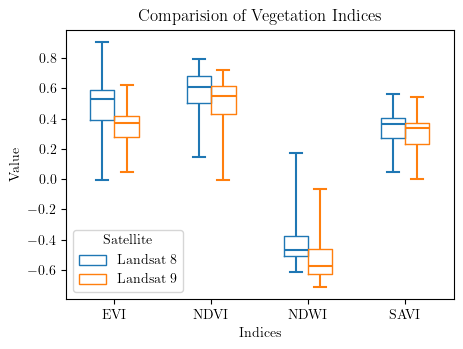

In [4]:
# Load the combined file into a DataFrame
file_path = Path("../Data/VegetationIndicesCombined.csv")
data_frame = pd.read_csv(file_path)

# Plotting box plot for each column
plt.figure(figsize=(5, 3.5))
sns.boxplot(x = 'Indices', y='Value', data=data_frame, hue='Satellite', fill = False, whis=(0,100), width=0.5, boxprops={'linewidth': 1})

plt.title('Comparision of Vegetation Indices', fontsize=12, fontweight='bold')
plt.xlabel('Indices', fontsize=10, fontweight='bold')
plt.ylabel('Value', fontsize=10, fontweight='bold')
plt.legend(title='Satellite', loc='lower left', fontsize=10)

plt.savefig('../Images/boxplot.png', dpi = 500, bbox_inches = 'tight')
plt.show()



<span style="font-family: 'Times New Roman', Times, serif; font-size: 1.5em;">Correlation</span>


In [86]:
def read_raster(raster):
    with rasterio.open(raster) as src:
        raster = src.read(1)
        flatten = raster.flatten()
        mask = ~np.isnan(flatten)
        flatten_mask  = flatten[mask]
        return flatten_mask
#Vegetation Index
landsat_8 = read_raster('../Data/EVI/landsat_8EVI.tif')
landsat_9 = read_raster('../Data/EVI/landsat_9EVI.tif')


In [11]:
import os
import numpy as np
import rasterio
import pandas as pd

def read_raster(raster_path):
    """Reads a raster file and returns the flattened, masked array (removing NaN values)."""
    with rasterio.open(raster_path) as src:
        raster = src.read(1)
        flatten = raster.flatten()  
        mask = ~np.isnan(flatten)  
        flatten_mask = flatten[mask]  # Apply the mask
    return flatten_mask

def calculate_metrics(raster1, raster2):
    """Calculates PBAIS, MAE, and RMSE between two raster datasets."""
    differences = raster1 - raster2
    
    # Calculate PBAIS
    pba = np.sum(differences) / np.sum(raster2) * 100
    
    # Calculate MAE
    mae = np.mean(np.abs(differences))
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean(differences**2))
    
    return pba, mae, rmse

def process_directory(base_dir):
    """Processes all seasonal directories, calculates metrics, and saves them to a CSV file."""
    results = []
    
    # Loop through each season directory in the base directory
    for season in sorted(os.listdir(base_dir)):
        season_path = os.path.join(base_dir, season)
        if os.path.isdir(season_path):
            # Find all pairs of tif files within the season directory
            landsat_8_file = None
            landsat_9_file = None
            
            for filename in os.listdir(season_path):
                if 'landsat_8' in filename:
                    landsat_8_file = os.path.join(season_path, filename)
                elif 'landsat_9' in filename:
                    landsat_9_file = os.path.join(season_path, filename)
                    
            if landsat_8_file and landsat_9_file:
                # Read rasters
                landsat_8 = read_raster(landsat_8_file)
                landsat_9 = read_raster(landsat_9_file)
                
                # Calculate metrics
                pba, mae, rmse = calculate_metrics(landsat_8, landsat_9)
                
                # Store results with the season name
                results.append({'Season': season, 'PBAIS (%)': pba, 'MAE': mae, 'RMSE': rmse})
    
    # Convert results to DataFrame
    df = pd.DataFrame(results)
    
    # Transpose the DataFrame
    df_transposed = df.set_index('Season').T
    
    # Save transposed DataFrame to CSV
    output_csv = os.path.join(base_dir, 'metrics_results.csv')
    df_transposed.to_csv(output_csv)

# Example usage
base_dir = '../Data/VegetationIndices/NDWI'
process_directory(base_dir)


In [87]:
# Landsat_8 and landsat_9 are numpy arrays
raster_data1 = np.array(landsat_8)
raster_data2 = np.array(landsat_9)

# Calculate differences
differences = raster_data1 - raster_data2

# Calculate PBAIS
pba = np.sum(differences) / np.sum(raster_data2) * 100

# Calculate MAE
mae = np.mean(np.abs(differences))

# Calculate RMSE
rmse = np.sqrt(np.mean(differences**2))

print(f"PBAIS: {pba:.2f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

PBAIS: -5.91%
MAE: 0.0326
RMSE: 0.0426


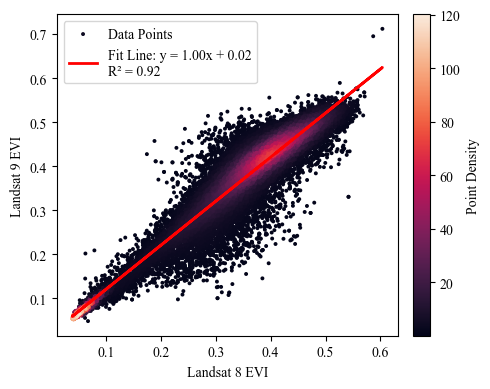

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib import gridspec
from scipy.stats import gaussian_kde

# Landsat_8 and landsat_9 are numpy arrays
raster_data1 = np.array(landsat_8)
raster_data2 = np.array(landsat_9)

# Reshape data for sklearn LinearRegression
raster_data1 = raster_data1.reshape(-1, 1)

# Perform linear regression on the full dataset
model = LinearRegression()
model.fit(raster_data1, raster_data2)
slope = model.coef_[0]
intercept = model.intercept_
r2 = r2_score(raster_data2, model.predict(raster_data1))

# Generate fit line
fit_line = model.predict(raster_data1)

# Compute density using Gaussian KDE
kde = gaussian_kde([raster_data1.flatten(), raster_data2.flatten()])
density = kde([raster_data1.flatten(), raster_data2.flatten()])

# Create the plot with gridspec
fig = plt.figure(figsize=(5, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1])  # Adjust width ratios as needed

# Main plot
ax0 = plt.subplot(gs[0])
scatter = ax0.scatter(raster_data1, raster_data2, c=density, cmap='rocket', edgecolor='none', alpha=1, s=8, label='Data Points')
ax0.plot(raster_data1, fit_line, color='red', linewidth=2, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}')
ax0.set_xlabel('Landsat 8 EVI', fontsize=10)
ax0.set_ylabel('Landsat 9 EVI', fontsize=10)
ax0.legend()
ax0.grid(False)

# Color bar
ax1 = plt.subplot(gs[1])
cb = plt.colorbar(scatter, cax=ax1)
cb.set_label('Point Density')

# Adjust the layout
plt.tight_layout()
plt.savefig('../Images/linearregEVI.png', dpi=500, bbox_inches='tight')
plt.show()


### Combined at once

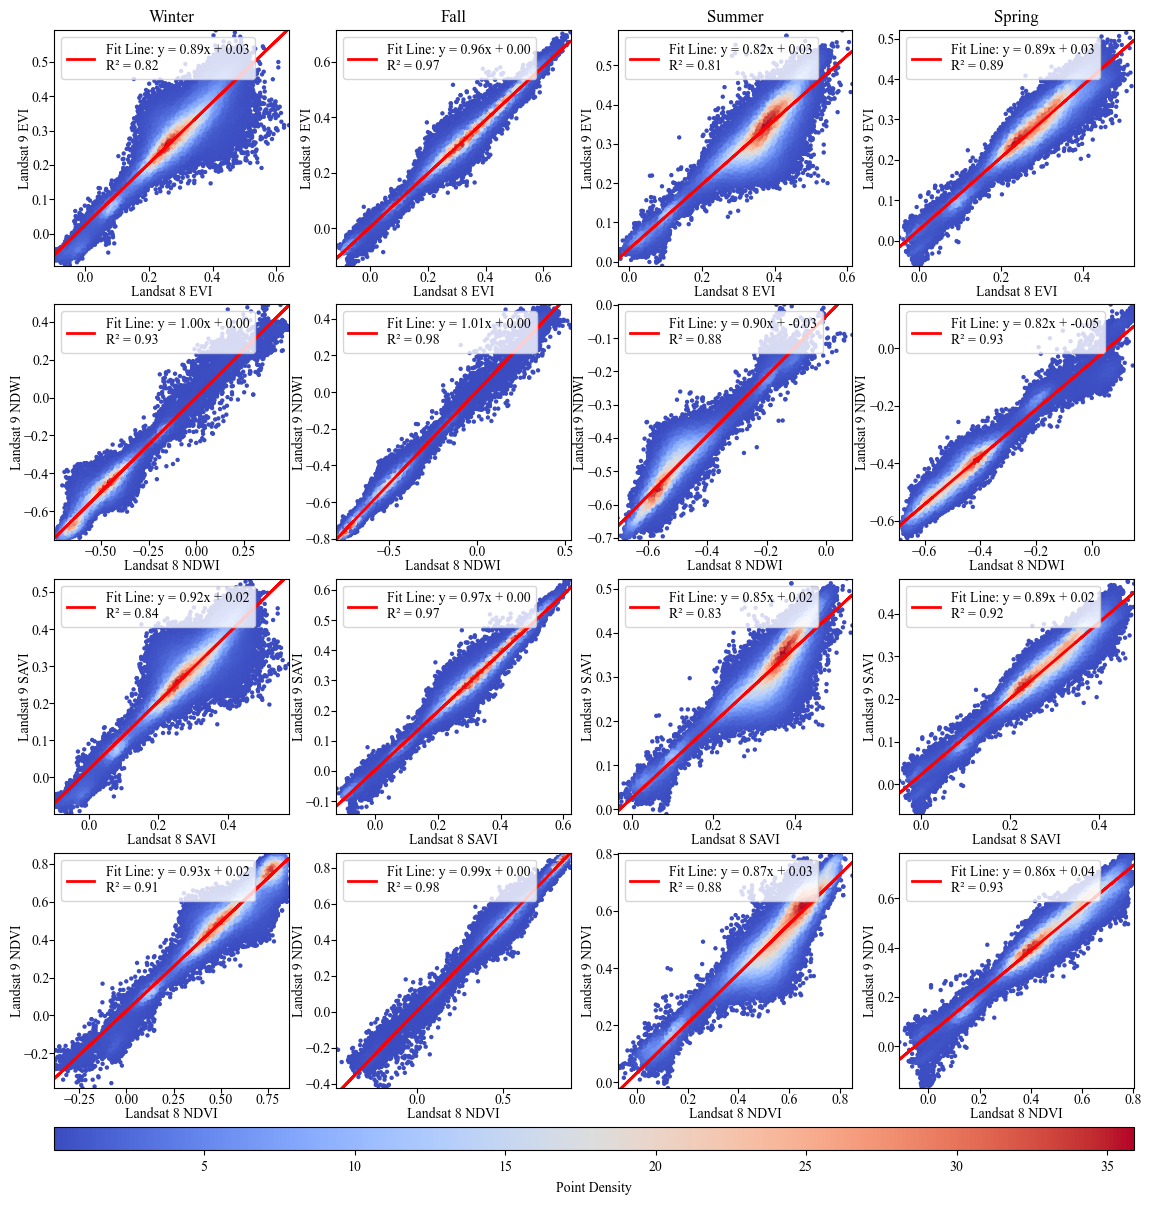

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
import rasterio
import os

def read_raster(raster):
    with rasterio.open(raster) as src:
        raster_data = src.read(1)
        flatten = raster_data.flatten()
        mask = ~np.isnan(flatten)
        valid_data = flatten[mask]

        return valid_data


def plot_vegetation_correlation(main_dir):
    vegetation_indices = [d for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]
    num_indices = len(vegetation_indices)

    # Create a figure
    fig = plt.figure(figsize=(12, 14))
    gs = gridspec.GridSpec(num_indices + 1, num_indices, height_ratios=[1] * num_indices + [0.1])

    scatter = None  # Initialize scatter variable to use in color bar

    # Create subplots
    for i, index in enumerate(vegetation_indices):
        index_dir = os.path.join(main_dir, index)
        seasons = [d for d in os.listdir(index_dir) if os.path.isdir(os.path.join(index_dir, d))]

        for j, season in enumerate(seasons):
            season_dir = os.path.join(index_dir, season)

            # Find Landsat 8 and 9 files
            files = [f for f in os.listdir(season_dir) if os.path.isfile(os.path.join(season_dir, f))]
            landsat_8_file = next((f for f in files if '8' in f), None)
            landsat_9_file = next((f for f in files if '9' in f), None)

            if landsat_8_file and landsat_9_file:
                landsat_8 = read_raster(os.path.join(season_dir, landsat_8_file))
                landsat_9 = read_raster(os.path.join(season_dir, landsat_9_file))

                # Reshape data for sklearn LinearRegression
                landsat_8 = landsat_8.reshape(-1, 1)

                # Perform linear regression
                model = LinearRegression()
                model.fit(landsat_8, landsat_9)
                slope = model.coef_[0]
                intercept = model.intercept_
                r2 = r2_score(landsat_9, model.predict(landsat_8))

                # Generate fit line
                fit_line = model.predict(landsat_8)

                # Compute density using Gaussian KDE
                kde = gaussian_kde([landsat_8.flatten(), landsat_9.flatten()])
                density = kde([landsat_8.flatten(), landsat_9.flatten()])

                # Create subplot
                ax = plt.subplot(gs[i, j])
                scatter = ax.scatter(landsat_8, landsat_9, c=density, cmap='coolwarm', edgecolor='none', alpha=1, s=10)
                ax.plot(landsat_8, fit_line, color='red', linewidth=2, label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}\nR² = {r2:.2f}')

                # Set axis labels
                ax.set_xlabel(f'Landsat 8 {index}', labelpad=0.03)
                ax.set_ylabel(f'Landsat 9 {index}', labelpad=0.03)

                # Adjust tick parameters
                ax.tick_params(axis='x', pad=0.0015)
                ax.tick_params(axis='y', pad=0.0015)

                # Dynamically set axis limits based on data range
                x_min, x_max = landsat_8.min(), landsat_8.max()
                y_min, y_max = landsat_9.min(), landsat_9.max()
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_min, y_max)

                # Keep aspect ratio uniform
                ax.set_aspect('auto')

                # Set title only for plots in the first row
                if i == 0:
                    ax.set_title(f'{season}')

                ax.legend(loc='upper left') 
                ax.grid(False)
            else:
                ax = plt.subplot(gs[i, j])
                ax.axis('off')

    # Create a color bar below the subplots
    cax = plt.subplot(gs[-1, :])
    cb = plt.colorbar(scatter, cax=cax, orientation='horizontal')
    cb.set_label('Point Density', labelpad=5)

    # Adjust the layout to make sure the color bar does not overlap with the plots
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, hspace=0.2, wspace=0.2)

    plt.savefig('../Images/vegetation_correlation1.png', dpi=500, bbox_inches='tight')
    plt.show()

# Directory containing folders for each vegetation index
main_directory = '../Data/VegetationIndices'
plot_vegetation_correlation(main_directory)


## LULC Plot and Classes Distribution

Water bodies: 7.53%
Shrubland: 34.36%
Grassland: 1.13%
Cropland: 26.31%
Urban: 29.23%


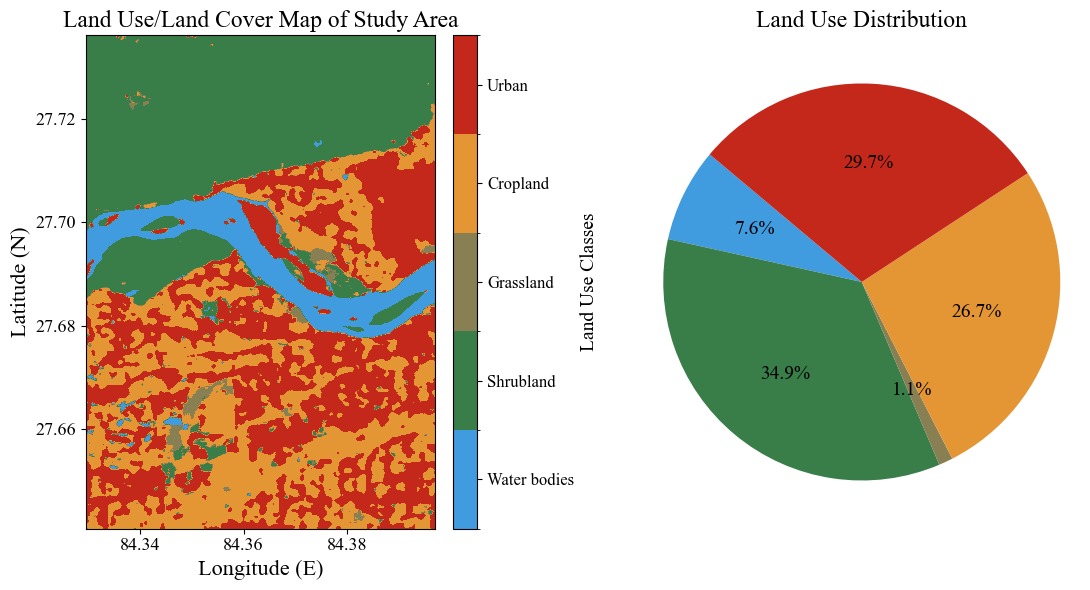

In [35]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from pathlib import Path

# Load the LULC data
lulc_path = Path('../Data/LULC5m.tif')
with rasterio.open(lulc_path) as src:
    lulc_data = src.read(1)
    transform = src.transform 
    bounds = src.bounds        

# Define the category names and corresponding colors
category_names = [
    'Water bodies', 'Shrubland', 'Grassland', 'Cropland', 'Urban'
]
colors = [
    '#419BDF', '#397D49', '#888053', '#E49635', '#C4281B'
]

# Map original categories to new indices
category_map = {
    0: 0,  # Water bodies
    1: 1,  # Shrubland
    2: 2,  # Grassland
    4: 3,  # Cropland
    6: 4   # Urban
}

# Apply the category map to the lulc_data
lulc_data_filtered = np.copy(lulc_data)
for original, new in category_map.items():
    lulc_data_filtered[lulc_data == original] = new

# Get unique values and their counts
unique, counts = np.unique(lulc_data_filtered, return_counts=True)
total_pixels = lulc_data_filtered.size
percentages = (counts / total_pixels) * 100

# Filter category names, colors, and percentages based on present classes
present_categories = [category_names[u] for u in unique if u < len(category_names)]
present_colors = [colors[u] for u in unique if u < len(colors)]
present_percentages = [percentages[np.where(unique == u)[0][0]] for u in unique if u < len(category_names)]

# Print the percentage of each land use category
for name, percentage in zip(present_categories, present_percentages):
    print(f"{name}: {percentage:.2f}%")

# Plot the LULC data and pie chart
fig, (ax, ax_pie) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1.5]})

# Define the boundaries and normalization based on the filtered categories
boundaries = np.arange(len(present_categories) + 1) - 0.5
norm = BoundaryNorm(boundaries, len(present_categories), clip=True)

# Use the extent parameter to set the coordinate system
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

im = ax.imshow(lulc_data_filtered, cmap=ListedColormap(present_colors), norm=norm, extent=extent)

# Adjust the position of the color bar to be closer to the raster
cbar = fig.colorbar(im, ax=ax, ticks=np.arange(len(present_categories)), spacing='proportional', shrink=1.0, pad=0.02)
cbar.set_label('Land Use Classes', fontsize=14)
cbar.set_ticks(np.arange(len(present_categories)))
cbar.set_ticklabels(present_categories)  # Only category names, no percentages
cbar.ax.tick_params(labelsize=12)  # Adjust color bar tick label size

# Plot the pie chart with percentage labels
ax_pie.pie(present_percentages, colors=present_colors, autopct=lambda p: f'{p:.1f}%', startangle=140, textprops={'fontsize': 14})
ax_pie.axis('equal') 
ax_pie.set_title('Land Use Distribution', fontsize=17)

# Set the title and labels for the raster
ax.set_title('Land Use/Land Cover Map of Study Area', fontsize=17)
ax.set_xlabel('Longitude (E)', fontsize=16)
ax.set_ylabel('Latitude (N)', fontsize=16)

# Adjust x and y tick label sizes
ax.tick_params(axis='both', which='major', labelsize=13)

# Show the plot
plt.tight_layout()

# Save the Image
plt.savefig('../Images/LULC.png', dpi=600, bbox_inches='tight')
plt.show()


### Evaluation metrics for each category of LULC

In [2]:
import rasterio
import numpy as np

# Function to read LULC raster and print the percentage of each unique class
def read_lulc_and_print_percentages(lulc_raster):
    with rasterio.open(lulc_raster) as src:
        lulc = src.read(1)
        unique, counts = np.unique(lulc, return_counts=True)
        total_pixels = lulc.size

        print("Percentage of each unique LULC class:")
        for value, count in zip(unique, counts):
            percentage = (count / total_pixels) * 100
            print(f"Class {value}: {percentage:.2f}%")

        return lulc

# Path to the LULC raster
lulc_path = '../Data/LULC.tif'

# Read the LULC raster and print the percentage of each unique class
lulc = read_lulc_and_print_percentages(lulc_path)


Percentage of each unique LULC class:
Class 0: 7.47%
Class 1: 34.38%
Class 2: 1.13%
Class 3: 0.03%
Class 4: 26.22%
Class 5: 0.11%
Class 6: 29.32%
Class 7: 1.27%
Class 8: 0.07%


In [6]:
import os
import rasterio
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to read raster data
def read_raster(raster_path):
    with rasterio.open(raster_path) as src:
        return src.read(1)

# Function to read LULC raster and return unique classes
def read_lulc(lulc_raster):
    with rasterio.open(lulc_raster) as src:
        lulc = src.read(1)
        unique_classes = np.unique(lulc)
        return lulc, unique_classes

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    pbias = 100 * np.sum(y_pred - y_true) / np.sum(y_true)
    return rmse, mae, pbias

def process_vegetation_indices(main_directory, lulc_path, output_csv_path):
    # Read LULC data and find unique classes
    lulc, unique_classes = read_lulc(lulc_path)

    # Initialize a list to store results
    results = []

    # Walk through all directories and subdirectories
    for vegetation_index in os.listdir(main_directory):
        veg_index_path = os.path.join(main_directory, vegetation_index)
        if os.path.isdir(veg_index_path):
            for season in os.listdir(veg_index_path):
                season_path = os.path.join(veg_index_path, season)
                if os.path.isdir(season_path):
                    # Find Landsat 8 and Landsat 9 files
                    landsat_8_path = None
                    landsat_9_path = None
                    for file in os.listdir(season_path):
                        if "landsat_8" in file:
                            landsat_8_path = os.path.join(season_path, file)
                        elif "landsat_9" in file:
                            landsat_9_path = os.path.join(season_path, file)

                    if landsat_8_path and landsat_9_path:
                        # Read rasters
                        landsat_8 = read_raster(landsat_8_path)
                        landsat_9 = read_raster(landsat_9_path)

                        # Iterate over each unique LULC class
                        for lulc_class in unique_classes:
                            # Mask data based on the current LULC class
                            mask = (lulc == lulc_class)
                            landsat_8_class = landsat_8[mask]
                            landsat_9_class = landsat_9[mask]

                            if landsat_8_class.size > 0 and landsat_9_class.size > 0:
                                # Calculate metrics
                                rmse, mae, pbias = calculate_metrics(landsat_9_class, landsat_8_class)

                                # Append results to the list
                                results.append({
                                    'Vegetation_Index': vegetation_index,
                                    'Season': season,
                                    'LULC_Class': lulc_class,
                                    'RMSE': rmse,
                                    'MAE': mae,
                                    'PBIAS': pbias
                                })

    # Convert the results to a DataFrame
    metrics_df = pd.DataFrame(results)

    # Save the DataFrame to a CSV file
    metrics_df.to_csv(output_csv_path, index=False)

    print(f"Metrics saved to {output_csv_path}")

# Example usage
main_directory = '../Data/VegetationIndices'
lulc_path = '../Data/LULC.tif'
output_csv_path = '../Data/VegetationIndices/LULCMetricsByLULCClass.csv'

process_vegetation_indices(main_directory, lulc_path, output_csv_path)


Metrics saved to ../Data/VegetationIndices/LULCMetricsByLULCClass.csv
